In [1]:
import h5py
import librosa
import pydub # faster than librosa
import numpy      as np
import pandas     as pd
import time

from coughvid.pytorch.coughvid_dataset import CoughvidDataset
from coughvid.pytorch.coswara_dataset import CoswaraDataset
from coughvid.pytorch.test_coughvid_dataset import TestCoughvidDataset
from torch.utils.data import DataLoader, SubsetRandomSampler
from coughvid.audio_processing.segmentation import segment_cough

#import torchvision.models as models

In [2]:
dir = 'C:/COUGHVID_public_dataset/public_dataset/'
dir = 'D:/COUGHVID_public_dataset/coswara/'

dataset         = CoswaraDataset(dir,get_features=True,get_leaf=True,samples_per_class=379)#CoughvidDataset(dir, 'metadata_compiled.csv', get_features=False,samples_per_class=100)
feature_dataset = CoswaraDataset(dir,get_features=True,get_leaf=False,samples_per_class=379)#CoughvidDataset(dir, 'metadata_compiled.csv', get_features=True,samples_per_class=100)


### NOTE: THIS IS ALREADY IMPLEMENTED IN THE DATALOADER CLASS ###
# get only records that have a COVID status label and a cough-detected above 0.8. Loading all the files takes too long
#data = dataset.dataframe
#status = np.isin(data['status'],[0,1,2])#['healthy','symptomatic','COVID-19'])
#cough_detected = data['cough_detected'] > 0.8 # recommended threshold from https://www.nature.com/articles/s41597-021-00937-4

#labelled_data = data[ np.logical_and(status,cough_detected) ]
#dataset.dataframe = labelled_data

# load data
batch_size = 1
num_workers = 2
dataloader         = DataLoader(dataset, num_workers=num_workers)#, batch_size=batch_size)
feature_dataloader = DataLoader(feature_dataset, num_workers=num_workers)#, batch_size=batch_size)

print(str(len(dataloader)) + " matching records found.")

ifdl = iter(feature_dataloader)
inputs, classes   = next(ifdl)
idl  = iter(dataloader)
inputs2, classes2 = next(idl)  

1731 matching records found.


tensor([[[-5.7168e+02, -5.7168e+02, -5.7168e+02,  ..., -5.7168e+02,
          -5.7168e+02, -5.7168e+02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [-3.0000e+00, -5.0892e-01,  2.6598e-01,  ...,  7.7710e+00,
           1.1416e+01,  7.4936e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  5.1400e+02,  3.1700e+02,  ...,  1.9200e+02,
           1.8000e+02,  1.8500e+02]]])
tensor([0], dtype=torch.int32)
torch.Size([1, 40, 120])
48000
[[[ -1.  -1.  -1. ... 240. 246. 248.]]]
torch.Size([1, 40, 120])
48000
[[[  0.   0.   0. ... 281. 285. 284.]]]
torch.Size([1, 40, 120])
48000


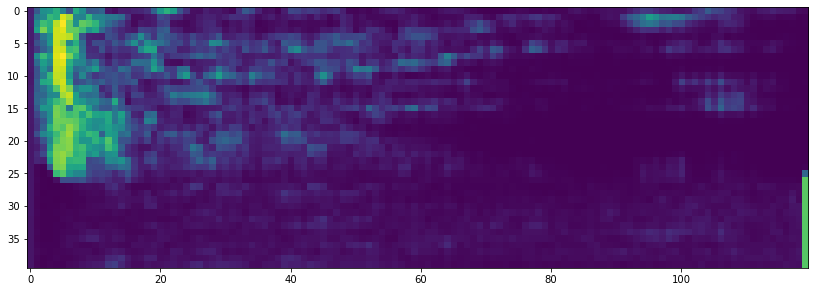

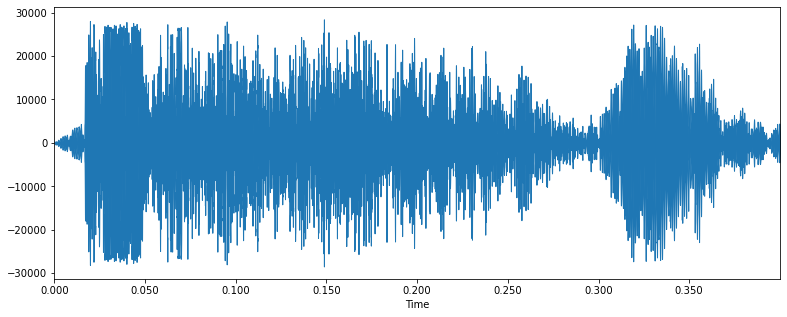

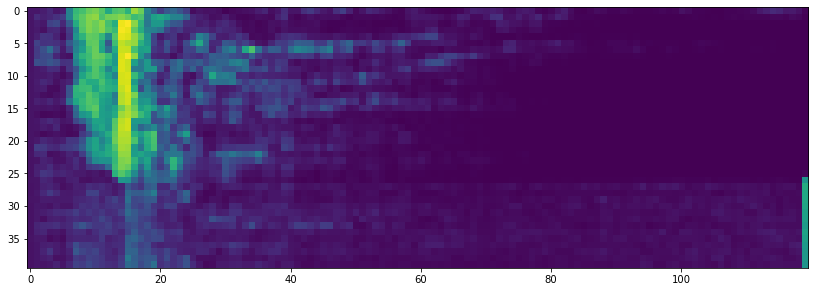

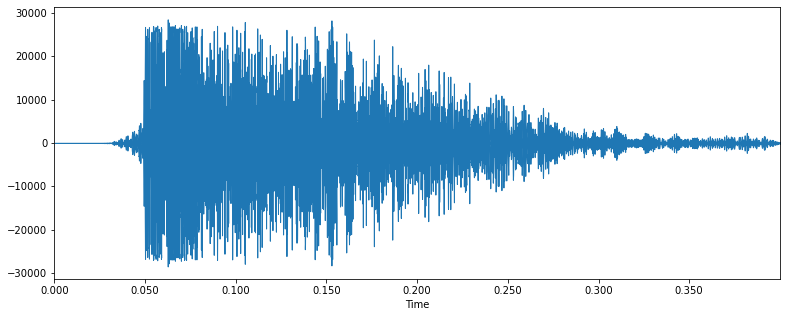

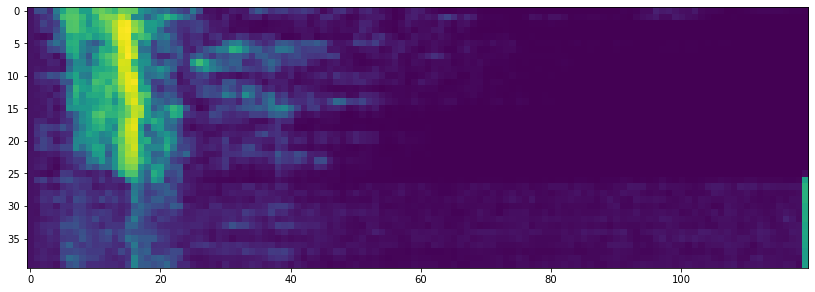

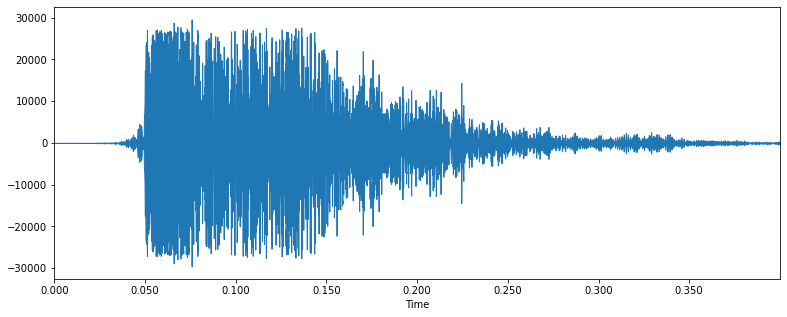

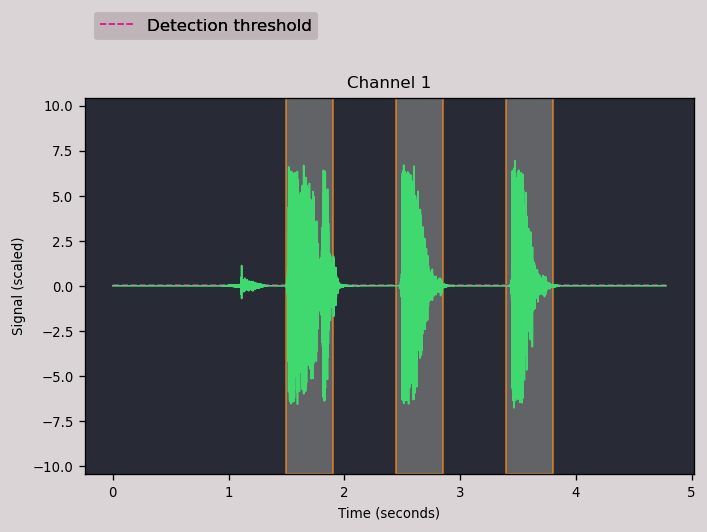

(1, 1, 19200)


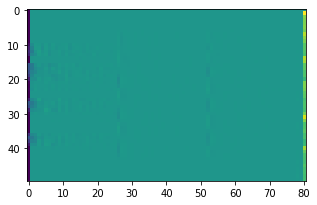

In [18]:
import matplotlib.pyplot as plt
import librosa.display

#if you want to implement the leaf function, ensure these library installed
import torch
import leaf_audio_pytorch.frontend as frontend
import leaf_audio_pytorch.initializers as initializers

#For audio split & random sample
import random
import auditok
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs, classes   = next(ifdl)
inputs2, classes2 = next(idl)  

assert classes == classes2

print(inputs)
print(classes)

#Leaf config and set up
n_filters = 40
window_len = 25.
window_stride = 15.
sample_rate = 48000

# complex_conv_init = initializers.GaborInit(sample_rate = sample_rate, min_freq = 60., max_freq = 7800.)
# custom_leaf = frontend.Leaf(n_filters = n_filters,
#                             window_len = window_len,
#                             sample_rate = sample_rate,
#                            window_stride = window_stride)
custom_leaf = frontend.Leaf()

#audio detection and seperation

filename = ''.join(inputs2)

audio_regions = auditok.split(
    filename,
    min_dur=0.4,     # minimum duration of a valid audio event in seconds
    max_dur=0.4,       # maximum duration of an event
    max_silence=0.1,#aximum duration of tolerated continuous silence within an event
    energy_threshold=40, # threshold of detection
    strict_min_dur=True
)


#as different clips dont share the same dimention, they cannot append together
for i, r in enumerate(audio_regions):
    audio = np.asarray(r)
    x = np.array([[audio]]).astype(np.float32)
    if i == 0:
        out = np.array([x])
    else:
        print(x)
        out = np.append(out,[x], axis = 0)
    x_np = torch.from_numpy(x)
#     x_np = x_np.cuda()
    features = custom_leaf(x_np)
    
    fig = features.detach().numpy()
    print(features.shape)
    plt.figure(figsize=(14, 5))
    plt.imshow(fig[0])
    plt.figure(figsize=(13, 5))
    librosa.display.waveplot(audio, sr=r.sr)
    print(r.sr)
    
region = auditok.load(filename) # returns an AudioRegion object
regions = region.splitp(min_dur=0.4,     # minimum duration of a valid audio event in seconds
    max_dur=0.4,       # maximum duration of an event
    max_silence=0.1, # maximum duration of tolerated continuous silence within an event
    energy_threshold=40,
    strict_min_dur=True
) # or just region.splitp()
    
print(x.shape)

# print(x.shape)

# x_np = torch.from_numpy(x)

# print(x_np.shape)
# features = custom_leaf(x_np)
# print(features.shape)
plt.figure(figsize=(5, 14))
plt.imshow(inputs[0].T)
# features_map = features()

# print(inputs[0].shape)


# plt.imshow(features)
# plt.figure(figsize=(14, 5))
# a = np.array(inputs2[0].tolist(),dtype='float')


# cough_segments, mask = segment_cough(a,48000)
# masked_audio = np.ma.masked_array(a,1-mask) 


#frames = dataset.extract_frames(masked_audio.compressed())
#librosa_mfcc = librosa.feature.mfcc(frames.flatten(), sr=48000, n_mfcc=39, n_mels=40, n_fft=512, hop_length=1024, power=2,center=False)
#plt.figure(figsize=(14, 5))

#plt.imshow(librosa_mfcc.T)

# plt.figure(figsize=(14, 5))

# #librosa.display.waveplot(masked_audio, sr=48000)
# plt.plot(a)
# plt.plot(mask)
# plt.title("Segmentation Output")

In [19]:
# tester = TestCoughvidDataset(dataset)
# tester.test_data_loader()
import IPython.display as ipd
ipd.Audio(filename)

In [20]:
tmp = random.choice(out)
print(tmp)

[[[ -36.  -48.  -59. ... 2645. 2388. 2084.]]]


In [21]:
from coughvid.audio_processing.split_cough import split_cough
split_cough(filename, duration = 0.4, max_silence=0.1, energy_threshold=50)

array([[[ -36.,  -48.,  -59., ..., 2645., 2388., 2084.]]], dtype=float32)